In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading all CPI CSV Data
bread_csv = pd.read_csv("bread_clean.csv")
coffee_csv = pd.read_csv("coffee_clean.csv")
eggs_csv = pd.read_csv("eggs_clean.csv")

#Find aggregate CPI data, stored as a dataframe
df_CPI = pd.concat([bread_csv, coffee_csv, eggs_csv]).groupby(level=0).mean()

# Federal Funds Rate Data 
df_FRED = pd.read_csv('./FRED_data.csv')

In [3]:
df_CPI.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2010.0,NaN,0.915002,-2.244567,-0.197901,-4.683961,0.254174,-0.294247,2.772519,7.499659,-5.134425,6.586959,0.219582
1,2011.0,2.781238,-3.381937,4.224444,3.317551,0.728083,0.912698,1.794906,1.752091,4.000727,-2.578325,-1.194416,0.013305
2,2012.0,1.594445,-2.676211,-0.441340,1.504306,-2.340447,-0.709814,0.973077,4.131549,-0.053682,2.894264,0.964955,0.373496
3,2013.0,-1.660972,-0.609682,0.924091,-2.076525,-0.999963,0.179683,-1.739263,-1.625791,0.544076,-0.561174,-0.116537,1.212811
4,2014.0,-0.258770,0.243087,0.374597,2.974705,-1.949347,-3.949789,3.405845,0.539220,0.372965,-1.277669,-0.587794,3.129825


In [4]:
df_FRED.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,2.47,2.44,1.98
1,1961,1.45,2.54,2.02,1.49,1.98,1.73,1.17,2.00,1.88,2.26,2.61,2.33
2,1962,2.15,2.37,2.85,2.78,2.36,2.68,2.71,2.93,2.90,2.90,2.94,2.93
3,1963,2.92,3.00,2.98,2.90,3.00,2.99,3.02,3.49,3.48,3.50,3.48,3.38
4,1964,3.48,3.48,3.43,3.47,3.50,3.50,3.42,3.50,3.45,3.36,3.52,3.85


In [5]:
# Step 1 — Melt year/month columns into long format
df_FRED = df_FRED.melt(
    id_vars = "Year",
    var_name = "Month",
    value_name = "Rate"
)

# Step 2 — Convert "Year" + "Month" → datetime
df_FRED['Date'] = pd.to_datetime(
    df_FRED['Year'].astype(str) + df_FRED['Month'],
    format = '%Y%b'
)

# Step 3 — Sort by date
df_FRED = df_FRED.sort_values('Date')

# Step 4 — Filter for 2010+
df_FRED = df_FRED[df_FRED['Date'] >= "2010-01-01"]

# Step 5 — Set Date as index
df_FRED = df_FRED.set_index('Date')

df_FRED.head()


,Year,Month,Rate
Date,,,
2010-01-01,2010,Jan,0.11
2010-02-01,2010,Feb,0.13
2010-03-01,2010,Mar,0.16
2010-04-01,2010,Apr,0.20
2010-05-01,2010,May,0.20


In [6]:
# Same Process for CPI data
df_long = df_CPI.melt(
    id_vars = "Year",
    var_name = "Month",
    value_name = "CPI"
)

df_long['Date'] = pd.to_datetime(
    df_long['Year'].astype(int).astype(str) + '-' + df_long['Month'],
    format='%Y-%b')

df_long['Year'] = df_long['Year'].astype(int)

# Add additional columns
df_CPI = df_long[['Date', 'Year', 'Month', 'CPI']].sort_values('Date').reset_index(drop=True)

df_CPI.head(15)


,Date,Year,Month,CPI
0,2010-01-01,2010,Jan,NaN
1,2010-02-01,2010,Feb,0.915002
2,2010-03-01,2010,Mar,-2.244567
3,2010-04-01,2010,Apr,-0.197901
4,2010-05-01,2010,May,-4.683961
5,2010-06-01,2010,Jun,0.254174
6,2010-07-01,2010,Jul,-0.294247
7,2010-08-01,2010,Aug,2.772519
8,2010-09-01,2010,Sep,7.499659
9,2010-10-01,2010,Oct,-5.134425


In [10]:
# Size of both datasets
print(len(df_FRED), len(df_CPI))

192 192


In [12]:
# Combine both datasets and drop any rows with NA data
# Align by index
df_CPI.index = df_FRED.index

# Combine
df_combined = pd.concat([df_FRED['Rate'], df_CPI['CPI']], axis=1)
df_combined.columns = ['FedFunds', 'CPI']

# Drop rows with NaNs
df_combined = df_combined.dropna()

# Check (4 rows should be cut)
print("Aligned shape after dropna:", df_combined.shape)
print("Any NaNs left?", df_combined.isna().any().any())


Aligned shape after dropna: (188, 2)
Any NaNs left? False


In [13]:
# 4 rows have been cut
df_combined.head(5)

,FedFunds,CPI
Date,,
2010-02-01,0.13,0.915002
2010-03-01,0.16,-2.244567
2010-04-01,0.20,-0.197901
2010-05-01,0.20,-4.683961
2010-06-01,0.18,0.254174


In [19]:
# Calculating b and c to minimize total cost

# Change in interest rates
df_x = df_combined['FedFunds'].diff()

# Change in inflation after 6 months
df_y = df_combined['CPI'].shift(-6) - df_combined['CPI']

# After changing the data to changes in interest rates and inflation, there will be more NA in the datasets which need to be cleared.
# AI assisted code for stacking and cleaning data
data = np.vstack([df_x.values, df_y.values]).T
data_clean = data[~np.isnan(data).any(axis=1)]

# Extract cleaned x and y
x = data_clean[:,0]
y = data_clean[:,1]

# AI assisted code for weights for each month
lambda_decay = 0.99
N = len(x)
w = lambda_decay ** (N - np.arange(N))

# Variables
wx = w * x        # w[i]*x[i]
wy = w * y        # w[i]*y[i]
wxx = w * x * x   # w[i]*x[i]^2
wxy = w * x * y   # w[i]*x[i]*y[i]

# Sums of Variables
W = np.sum(w)
Sx  = np.sum(wx) 
Sy  = np.sum(wy)
Sxx = np.sum(wxx)
Sxy = np.sum(wxy)

# Calculate a and b
b = (Sxy - ((Sx * Sy) / W)) / (Sxx - ((Sx*Sx) / W))
c = (Sy - b * Sx) / W

# Final Regression Line for 6 months
y_pred_6 = b * x + c

In [119]:
print(f"b = {b}")
print(f"c = {c}")

b = -1.253458298086286
c = -0.12419794238777411


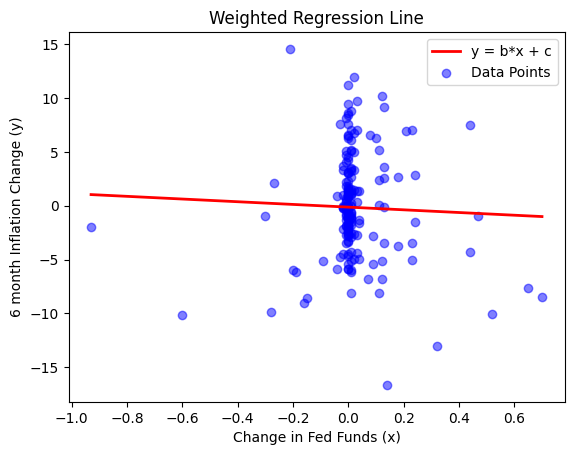

In [18]:
# Weighted regression line
x_line = np.linspace(min(x), max(x), 100)
y_line = b * x_line + c

plt.plot(x_line, y_line, color='red', linewidth=2, label="y = b*x + c")
plt.scatter(x, y, color='blue', alpha=0.5, label = "Data Points")

plt.xlabel("Change in Fed Funds (x)")
plt.ylabel("6 month Inflation Change (y)")
plt.title("Weighted Regression Line")
plt.legend()
plt.show()